In [1]:
import numpy as np
import pandas as pd
import functions as f
import missingno as msno
import matplotlib.pyplot as plt
from IPython.display import display

# Datenaufbereitung und Fehleranalyse: clickstreams.parquet

Dieser Notebook führt eine systematische Datenbereinigung und Fehleranalyse durch:
1. Laden und allgemeine Inspektion der Daten
2. Prüfung auf Duplikate
3. Analyse fehlender Werte
4. Bereinigung von '-unknown-' Werten
5. Detaillierte Analyse aller Spalten
6. Visualisierung fehlender Werte mit missingno
7. Export der bereinigten Daten

## 1. Daten laden und allgemeine Inspektion

In [ ]:
# Daten laden
df_clickstreams = pd.read_csv('data/new_clickstreams_.csv')

rows_initial = len(df_clickstreams)
print(f"Anzahl der Zeilen: {rows_initial:,}")
print(f"Anzahl der Spalten: {len(df_clickstreams.columns)}")
print(f"\nSpalten: {list(df_clickstreams.columns)}")

Anzahl der Zeilen: 10,567,737
Anzahl der Spalten: 6

Spalten: ['session_user_id', 'session_action', 'session_action_type', 'session_action_detail', 'session_device_type', 'time_passed_in_seconds']


In [3]:
df_clickstreams.head(25)

,session_user_id,session_action,session_action_type,session_action_detail,session_device_type,time_passed_in_seconds
0,d1mm9tcy42,lookup,None,None,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,None,None,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,None,None,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,None,None,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,None,None,Windows Desktop,683.0


In [4]:
df_clickstreams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   session_user_id         object 
 1   session_action          object 
 2   session_action_type     object 
 3   session_action_detail   object 
 4   session_device_type     object 
 5   time_passed_in_seconds  float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [5]:
df_clickstreams.describe()

,time_passed_in_seconds
count,1.043171e+07
mean,1.940581e+04
std,8.888424e+04
min,0.000000e+00
25%,2.290000e+02
50%,1.147000e+03
75%,8.444000e+03
max,1.799977e+06


## 2. Prüfung auf Duplikate

In [6]:
# Duplikate prüfen
num_duplicates = df_clickstreams.duplicated().sum()
print(f"Anzahl der Duplikate: {num_duplicates:,}")
print(f"Prozentsatz: {num_duplicates / rows_initial * 100:.2f}%")
print('-' * 60)

# Duplikate aus df_clickstreams entfernen
df_clickstreams = df_clickstreams.drop_duplicates()
print('Duplikate entfernt.')


Anzahl der Duplikate: 252,536
Prozentsatz: 2.39%
------------------------------------------------------------
Duplikate entfernt.


## 3. Analyse fehlender Werte (vor Bereinigung)

In [7]:
# Fehlende Werte pro Spalte
missing_before = df_clickstreams.isnull().sum()
missing_pct = (missing_before / rows_initial * 100).round(2)

missing_df = pd.DataFrame({
    'Spalte': missing_before.index,
    'Fehlend': missing_before.values,
    'Prozent': missing_pct.values
})
missing_df = missing_df.sort_values('Fehlend', ascending=False)
missing_df

,Spalte,Fehlend,Prozent
2,session_action_type,1071409,10.14
3,session_action_detail,1071409,10.14
5,time_passed_in_seconds,135535,1.28
1,session_action,78349,0.74
0,session_user_id,29308,0.28
4,session_device_type,0,0.00


## 4. Analyse und Bereinigung von '-unknown-' Werten

'-unknown-' ist ein Platzhalter für unbekannte Werte und sollte durch NaN ersetzt werden.

In [8]:
# Analyse von '-unknown-' Werten
text_cols = ['session_user_id', 'session_action', 'session_action_type', 'session_action_detail', 'session_device_type']

print("Anzahl der '-unknown-' Werte pro Spalte:\n")
for col in text_cols:
    count = (df_clickstreams[col] == '-unknown-').sum()
    pct = count / rows_initial * 100
    df_clickstreams[col] = df_clickstreams[col].replace('-unknown-', np.nan)
    print(f"{col}: {count:,} ({pct:.2f}%) Werte ersetzt")

Anzahl der '-unknown-' Werte pro Spalte:

session_user_id: 0 (0.00%) Werte ersetzt
session_action: 0 (0.00%) Werte ersetzt
session_action_type: 1,007,974 (9.54%) Werte ersetzt
session_action_detail: 1,007,945 (9.54%) Werte ersetzt
session_device_type: 209,533 (1.98%) Werte ersetzt


## 5. Analyse der Spalten nach Bereinigung

In [9]:
# session_user_id
print("=== session_user_id ===")
print(f"Eindeutige Benutzer: {df_clickstreams['session_user_id'].nunique():,}")
print(f"Fehlende Werte: {df_clickstreams['session_user_id'].isna().sum():,}")

=== session_user_id ===
Eindeutige Benutzer: 135,483
Fehlende Werte: 29,308


In [10]:
cols_to_analyse = ['session_action', 'session_action_type', 'session_action_detail', 'session_device_type']
f.print_unique_values_summary(df_clickstreams, cols_to_analyse)

=== session_action ===
Eindeutige Werte: 359
Fehlende Werte: 78,349

Top 10 häufigste Werte:
'show' - 2,658,295 - 25.77%
'index' - 836,332 - 8.11%
'search_results' - 716,127 - 6.94%
'personalize' - 692,948 - 6.72%
'search' - 524,839 - 5.09%
'ajax_refresh_subtotal' - 476,441 - 4.62%
'update' - 362,726 - 3.52%
'similar_listings' - 348,706 - 3.38%
'social_connections' - 331,799 - 3.22%
'reviews' - 311,367 - 3.02%


=== session_action_type ===
Eindeutige Werte: 9
Fehlende Werte: 2,079,383

Top 10 häufigste Werte:
'view' - 3,476,890 - 33.71%
'data' - 2,054,410 - 19.92%
'click' - 1,959,791 - 19.00%
'submit' - 620,116 - 6.01%
'message_post' - 85,736 - 0.83%
'partner_callback' - 19,077 - 0.18%
'booking_request' - 18,657 - 0.18%
'modify' - 1,137 - 0.01%
'booking_response' - 4 - 0.00%


=== session_action_detail ===
Eindeutige Werte: 154
Fehlende Werte: 2,079,354

Top 10 häufigste Werte:
'view_search_results' - 1,752,489 - 16.99%
'p3' - 1,338,607 - 12.98%
'wishlist_content_update' - 692,948 - 6.

# 6. Zeitanalyse

In [11]:
# time_passed_in_seconds
print("=== time_passed_in_seconds ===")
time_col = df_clickstreams['time_passed_in_seconds']
print(f"Fehlende Werte: {time_col.isna().sum():,}")
print(f"Min: {time_col.min()}")
print(f"Max: {time_col.max()}")
print(f"Mittelwert: {time_col.mean():.2f}")
print(f"Median: {time_col.median():.2f}")
print(f"Standardabweichung: {time_col.std():.2f}")

extreme_time = time_col > 1800  # > 30 Minuten
print(f"\nUnrealistische Werte (> 30 Minuten): {extreme_time.sum():,} ({(extreme_time.sum() / len(df_clickstreams) * 100):.2f}%)")

zero_time = time_col == 0 # = 0 Sekunden
print(f"Null-Werte (= 0 Sekunden): {zero_time.sum():,} ({(zero_time.sum() / len(df_clickstreams) * 100):.2f}%)")

=== time_passed_in_seconds ===
Fehlende Werte: 135,535
Min: 0.0
Max: 1799977.0
Mittelwert: 19878.66
Median: 1219.00
Standardabweichung: 89925.88

Unrealistische Werte (> 30 Minuten): 4,450,910 (43.15%)
Null-Werte (= 0 Sekunden): 57,615 (0.56%)


Mehr als 30 Minuten Inaktivität innerhalb einer Sitzung sind ein unrealistischer Wert.

Möglicherweise entstehen solche Werte, wenn ein Benutzer den Tab geöffnet lässt und weggeht, später zurückkehrt und die nächste Aktion ausführt. Es handelt sich dann eigentlich bereits um eine neue Sitzung.

Daher fügen wir eine Spalte `is_new_session` hinzu, in der 1 steht, wenn `time_passed_in_seconds` größer als 30 Minuten ist, und 0, wenn sie kleiner ist.

In [12]:
df_clickstreams['is_new_session'] = extreme_time  # Markiere als neue Sitzung, wenn Zeit > 30 Minuten

In [13]:
# Detaillierte Analyse der Einträge mit time_passed_in_seconds == 0
df_zero_time = df_clickstreams[time_col == 0]

f.print_unique_values_summary(df_zero_time, cols_to_analyse)

=== session_action ===
Eindeutige Werte: 219
Fehlende Werte: 4,705

Top 10 häufigste Werte:
'show' - 9,691 - 16.82%
'pending' - 4,345 - 7.54%
'personalize' - 3,244 - 5.63%
'index' - 2,965 - 5.15%
'ajax_refresh_subtotal' - 2,443 - 4.24%
'click' - 2,068 - 3.59%
'similar_listings' - 2,065 - 3.58%
'search_results' - 1,771 - 3.07%
'reviews' - 1,629 - 2.83%
'update' - 1,498 - 2.60%


=== session_action_type ===
Eindeutige Werte: 8
Fehlende Werte: 12,283

Top 10 häufigste Werte:
'view' - 12,258 - 21.28%
'data' - 10,937 - 18.98%
'click' - 9,509 - 16.50%
'message_post' - 4,814 - 8.36%
'booking_request' - 4,333 - 7.52%
'submit' - 3,357 - 5.83%
'partner_callback' - 123 - 0.21%
'booking_response' - 1 - 0.00%


=== session_action_detail ===
Eindeutige Werte: 124
Fehlende Werte: 12,283

Top 10 häufigste Werte:
'message_post' - 4,814 - 8.36%
'pending' - 4,333 - 7.52%
'p3' - 4,272 - 7.41%
'view_search_results' - 4,250 - 7.38%
'wishlist_content_update' - 3,244 - 5.63%
'user_profile' - 2,452 - 4.26%
'ch

In `df_zero_time` wird eine Verteilung der Werte beobachtet, die sich vom `df_clickstreams` unterscheidet:

- `session_action`:
    - 'pending': 7.54%, in `df_clickstreams` nicht in den Top-15;
- `session_action_type`:
    - 'message_post': 8.36%, in `df_clickstreams`: 0.82%;
    - 'booking_request': 7.52%, in `df_clickstreams`: 0.18%;
- `session_action_detail`:
    - 'message_post': 8.36%, in `df_clickstreams` nicht in den Top-15;
    - 'pending': 7.52%, in `df_clickstreams` nicht in den Top-15;

Möglicherweise sind solche Zeilen automatische Einträge, die unmittelbar nach irgendwelcher anderen Aktion entstehen. 
Zum Beispiel gibt es insgesamt 4.333 Zeilen mit `session_action_type=booking_request` und `time_passed_in_seconds=0`, was einen erheblichen Anteil aller 18.773 Buchungen ausmacht. Daher wurde entschieden, die Zeilen mit `time_passed_in_seconds=0` zu behalten.

## 7. Fehlende Werte nach Bereinigung

In [14]:
# Fehlende Werte nach Bereinigung
missing_after = df_clickstreams.isnull().sum()
missing_pct_after = (missing_after / rows_initial * 100).round(2)

missing_df_after = pd.DataFrame({
    'Spalte': missing_after.index,
    'Fehlend': missing_after.values,
    'Prozent': missing_pct_after.values
})
missing_df_after = missing_df_after.sort_values('Fehlend', ascending=False)
missing_df_after

,Spalte,Fehlend,Prozent
2,session_action_type,2079383,19.68
3,session_action_detail,2079354,19.68
4,session_device_type,209533,1.98
5,time_passed_in_seconds,135535,1.28
1,session_action,78349,0.74
0,session_user_id,29308,0.28
6,is_new_session,0,0.00


In [15]:
# Löschen der Zeilen mit fehlenden session_user_id, session_action und time_passed_in_seconds
df_clickstreams = df_clickstreams.dropna(subset=['session_user_id', 'session_action', 'time_passed_in_seconds'])

del missing_df_after

## 7. Visualisierung fehlender Werte mit missingno

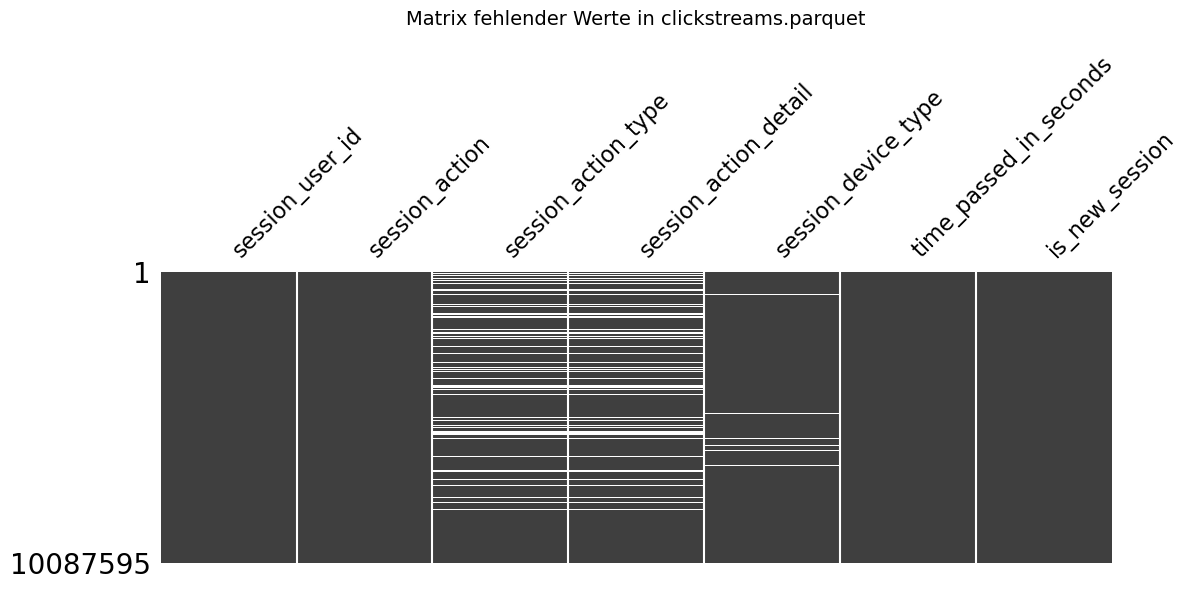

In [16]:
# Matrix-Plot
msno.matrix(df_clickstreams, sparkline=False, figsize=(12, 6))
plt.title('Matrix fehlender Werte in clickstreams.parquet', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

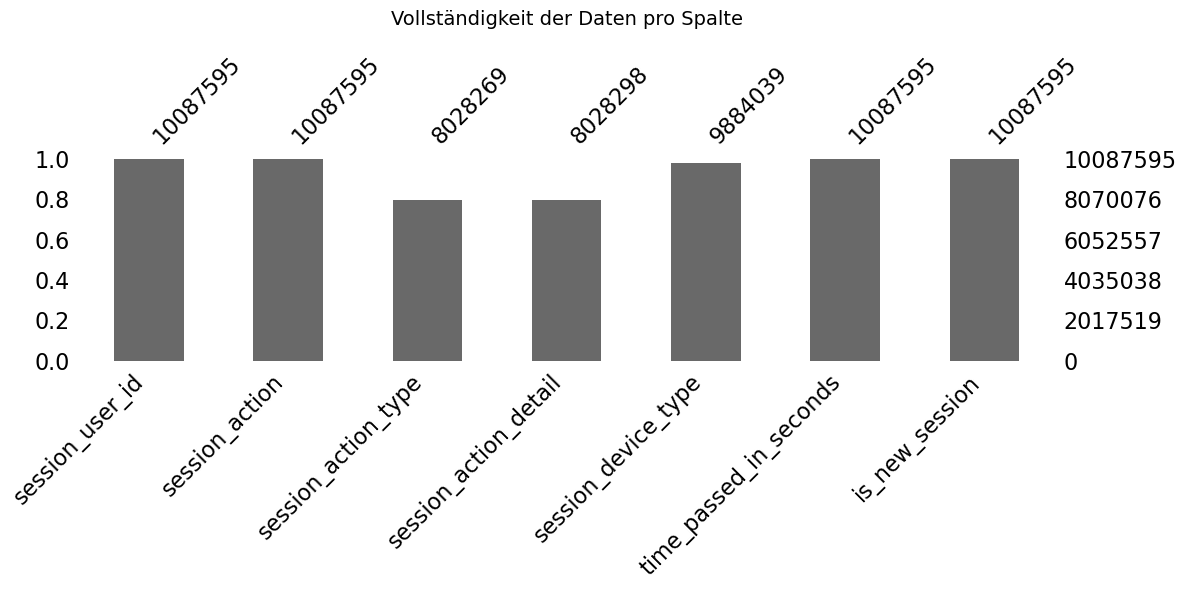

In [17]:
# Bar-Plot
msno.bar(df_clickstreams, figsize=(12, 6))
plt.title('Vollständigkeit der Daten pro Spalte', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

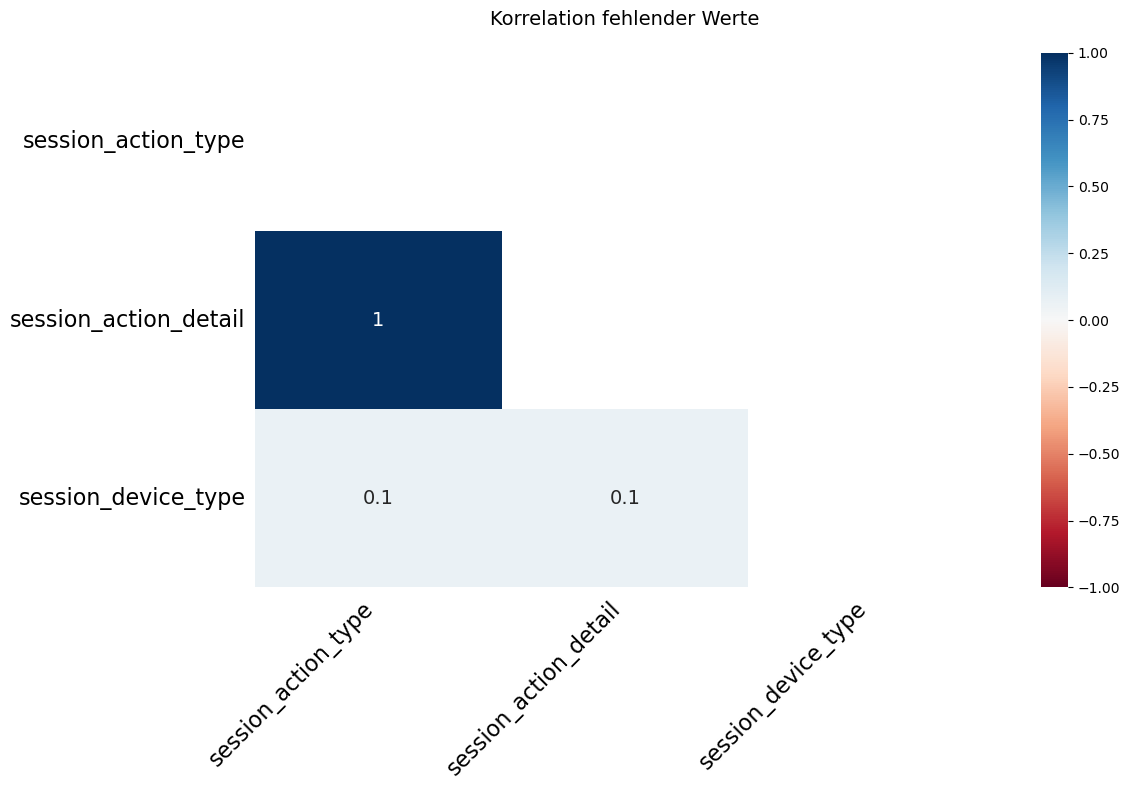

In [18]:
# Heatmap-Plot
msno.heatmap(df_clickstreams, figsize=(12, 8))
plt.title('Korrelation fehlender Werte', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## 8. Zusammenfassung

In [19]:
print(f"Ursprüngliche Anzahl der Zeilen: {rows_initial:,}")
print(f"Finale Anzahl der Zeilen: {len(df_clickstreams):,}")
print(f"Entfernte Zeilen gesamt: {rows_initial - len(df_clickstreams)} ({((rows_initial - len(df_clickstreams)) / rows_initial * 100):.2f}%)")
print(f"Anzahl der Spalten: {len(df_clickstreams.columns)}")

print("\nDurchgeführte Bereinigungen:")
print("1. Duplikate entfernt;")
print("2. `-unknown-` in `session_action_type`, `session_action_detail` und `session_device_type` durch NaN ersetzt;")
print("3. Zeilen mit fehlenden `session_user_id`, `session_action` und `time_passed_in_seconds` entfernt.")

Ursprüngliche Anzahl der Zeilen: 10,567,737
Finale Anzahl der Zeilen: 10,087,595
Entfernte Zeilen gesamt: 480142 (4.54%)
Anzahl der Spalten: 7

Durchgeführte Bereinigungen:
1. Duplikate entfernt;
2. `-unknown-` in `session_action_type`, `session_action_detail` und `session_device_type` durch NaN ersetzt;
3. Zeilen mit fehlenden `session_user_id`, `session_action` und `time_passed_in_seconds` entfernt.


In [20]:
# Speichere die Zusammenfassung der eindeutigen Werte pro Spalte
f.save_unique_values_summary(df_clickstreams, cols_to_analyse, 'clickstreams')

Datei erfolgreich gespeichert: outputs/clickstreams_unique_values_summary.txt


In [21]:
# Export der bereinigten Daten
df_clickstreams.to_parquet('data/clickstreams_filtered.parquet', index=False)
print("Bereinigte Daten erfolgreich in 'data/clickstreams_filtered.parquet' exportiert")

Bereinigte Daten erfolgreich in 'data/clickstreams_filtered.parquet' exportiert
